In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install --quiet lightning
! pip install --quiet transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 61.3 MB/s eta 0:00:00


In [3]:
! pip install --quiet accelerate -U
! pip install --quiet transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 5.7 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import re
import string
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import torchmetrics
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [5]:
import transformers

In [6]:
test_path = '/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/Data/new_essay_val_preprocessed.csv'
deploytest_path = '/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/Data/test_data_preprocessed.csv'

df_test = pd.read_csv(test_path)
df_deploy = pd.read_csv(deploytest_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## datasets preparation

In [7]:
class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        record = self.dataframe.iloc[idx]
        text = record['text']
        label = record['label']

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label, dtype=torch.long)
        }

In [8]:
class TextMetaDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

        meta_features = dataframe[['sentence_variation', '%stop_word_total', 'mean_word_length', '%adjectives_total']]
        self.scaler = StandardScaler()
        self.scaler.fit(meta_features)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        record = self.dataframe.iloc[idx]
        text = record['text']
        label = record['label']
        metafeatures = [
            record['sentence_variation'],
            record['%stop_word_total'],
            record['mean_word_length'],
            record['%adjectives_total']
        ]

        metafeatures = self.scaler.transform([metafeatures])[0]

        # Tokenize the text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Extract input_ids and attention_mask
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        metafeatures = torch.tensor(metafeatures, dtype=torch.float)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'meta_features': metafeatures,
            'label': torch.tensor(label, dtype=torch.long)
        }

## model set up for loading

In [9]:
class CombinedModel(nn.Module):
    def __init__(self, gpt2_model_name, num_meta_features):
        super(CombinedModel, self).__init__()
        # load the pre-trained GPT-2 model
        self.gpt2 = transformers.GPT2Model.from_pretrained(gpt2_model_name)

        # define a simple feedforward network for meta-features
        self.meta_feature_ffn = nn.Sequential(
            nn.Linear(num_meta_features, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU()
        )

        # output layer that combines the features from GPT-2 and meta-features
        self.classifier = nn.Linear(self.gpt2.config.n_embd + 16, 2)

    def forward(self, input_ids, attention_mask, meta_features):
        # pass text through GPT-2
        gpt2_output = self.gpt2(input_ids=input_ids, attention_mask=attention_mask)
        text_embedding = gpt2_output.last_hidden_state[:, 0, :]

        # pass meta-features through the feedforward network
        meta_features_embedding = self.meta_feature_ffn(meta_features)

        # concatenate text and meta-features embeddings
        combined_embedding = torch.cat((text_embedding, meta_features_embedding), dim=1)

        # classify using the combined features
        logits = self.classifier(combined_embedding)

        return logits

In [13]:
class MetaLightningModule(pl.LightningModule):
    def __init__(self, model_name, config, num_labels=2):
        super().__init__()
        self.model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

        self.meta_feature_processor = nn.Sequential(
            nn.Linear(4, 16),  # 4 metafeatures
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU()
        )

        combined_features_dim = self.model.config.hidden_size + 16
        self.classifier = nn.Linear(combined_features_dim, num_labels)

    def forward(self, input_ids, attention_mask, meta_features):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.hidden_states[-1]
        sequence_features = last_hidden_state[:, 0, :]

        meta_features = self.meta_feature_processor(meta_features)

        combined_features = torch.cat((sequence_features, meta_features), dim=1)

        logits = self.classifier(combined_features)
        return logits

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        meta_features = batch['meta_features']
        labels = batch['label']
        logits = self(input_ids, attention_mask, meta_features)
        loss = F.cross_entropy(logits, labels)
        preds = torch.argmax(logits, dim=1)
        probs = torch.softmax(logits, dim=1)[:, 1]
        self.log('train_loss', loss, on_step=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        meta_features = batch['meta_features']
        labels = batch['label']
        logits = self(input_ids, attention_mask, meta_features)
        loss = F.cross_entropy(logits, labels)
        preds = torch.argmax(logits, dim=1)
        probs = torch.softmax(logits, dim=1)[:, 1]
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=2e-5)
        return optimizer

## model utility

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import (precision_recall_curve, roc_curve, auc, roc_auc_score,
                             precision_score, recall_score, f1_score, accuracy_score,
                             confusion_matrix, ConfusionMatrixDisplay)

class ModelUtility:
    def __init__(self, model, device, acceptable_recall=0.80):
        self.model = model
        self.device = device
        self.acceptable_recall = acceptable_recall

    def model_predict(self, test_loader, return_labels=False):
        self.model.eval()  # Set the model to evaluation mode
        true_labels = []
        predicted_probs = []
        predicted_labels = []

        with torch.no_grad():
            for batch in test_loader:
                inputs = {
                    'input_ids': batch['input_ids'].to(self.device),
                    'attention_mask': batch['attention_mask'].to(self.device)
                }

                if 'meta_features' in batch:
                    inputs['meta_features'] = batch['meta_features'].to(self.device)

                if return_labels:
                    labels = batch['label'].to(self.device)

                outputs = self.model(**inputs)
                logits = outputs if isinstance(outputs, torch.Tensor) else outputs.logits

                probs = torch.softmax(logits, dim=1)
                pos_probs = probs[:, 1]
                preds = torch.argmax(probs, dim=1)

                predicted_probs.extend(pos_probs.cpu().numpy())
                predicted_labels.extend(preds.cpu().numpy())
                if return_labels:
                    true_labels.extend(labels.cpu().numpy())

        return (predicted_probs, predicted_labels, true_labels) if return_labels else (predicted_probs, predicted_labels)

    def model_threshold(self, true_labels, probabilities):
        precision, recall, thresholds = precision_recall_curve(true_labels, probabilities)
        auprc = auc(recall, precision)
        print(f"AUPRC: {auprc:.4f}")

        auroc = roc_auc_score(true_labels, probabilities)
        print(f"AUROC: {auroc:.4f}")

        acceptable_indices = np.where(recall >= self.acceptable_recall)[0]
        if len(acceptable_indices) > 0:
            optimal_idx = acceptable_indices[np.argmax(precision[acceptable_indices])]
            optimal_threshold = thresholds[optimal_idx]
            print(f"Optimal Threshold: {optimal_threshold:.4f}")
            return optimal_threshold
        else:
            print("No threshold found with the recall above or equal to the acceptable level.")
            return None


    def model_test(self, true_labels, probabilities, threshold=0.50):
        probabilities = np.array(probabilities)

        precision, recall, thresholds_prc = precision_recall_curve(true_labels, probabilities)
        auprc = auc(recall, precision)
        print(f"AUPRC: {auprc:.4f}")

        fpr, tpr, thresholds_roc = roc_curve(true_labels, probabilities)
        auroc = roc_auc_score(true_labels, probabilities)
        print(f"AUROC: {auroc:.4f}")

        predictions = (probabilities >= threshold).astype(int)

        precision_score_val = precision_score(true_labels, predictions)
        recall_score_val = recall_score(true_labels, predictions)
        f1_score_val = f1_score(true_labels, predictions)
        accuracy_score_val = accuracy_score(true_labels, predictions)

        print(f"Threshold: {threshold:.4f}")
        print(f"Precision: {precision_score_val:.4f}")
        print(f"Recall: {recall_score_val:.4f}")
        print(f"F1 Score: {f1_score_val:.4f}")
        print(f"Accuracy: {accuracy_score_val:.4f}")

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

        # Precision-Recall Curve
        ax1.plot(recall, precision, label=f'PR Curve (area = {auprc:.2f})')
        ax1.set_xlabel('Recall')
        ax1.set_ylabel('Precision')
        ax1.set_title('Precision-Recall Curve')
        ax1.legend(loc="best")
        ax1.grid(True)

        # ROC Curve
        ax2.plot(fpr, tpr, label=f'ROC Curve (area = {auroc:.2f})')
        ax2.plot([0, 1], [0, 1], 'r--')
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.set_title('ROC Curve')
        ax2.legend(loc="best")
        ax2.grid(True)

        # Confusion Matrix
        cm = confusion_matrix(true_labels, predictions)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(cmap=plt.cm.Blues, ax=ax3)
        ax3.set_title('Confusion Matrix')
        ax3.set_xlabel('Predicted Labels')
        ax3.set_ylabel('True Labels')

        plt.tight_layout()
        plt.show()


# GPT2

In [13]:
tokenizer = transformers.GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
data_collator = transformers.DataCollatorWithPadding(tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

## text only

In [14]:
test_dataset = TextDataset(df_test, tokenizer)
deploy_dataset = TextDataset(df_deploy, tokenizer)

test_loader = DataLoader(dataset=test_dataset, batch_size=1)
deploy_loader = DataLoader(dataset=deploy_dataset, batch_size=1)

In [15]:
model = torch.load('/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/models/GPT2/GPT2-kaggle-nometa.pth')
model.to(device)
model_utility = ModelUtility(model, device)

AUPRC: 0.9587
AUROC: 0.9437
Threshold: 0.5000
Precision: 0.7600
Recall: 0.9500
F1 Score: 0.8444
Accuracy: 0.8250


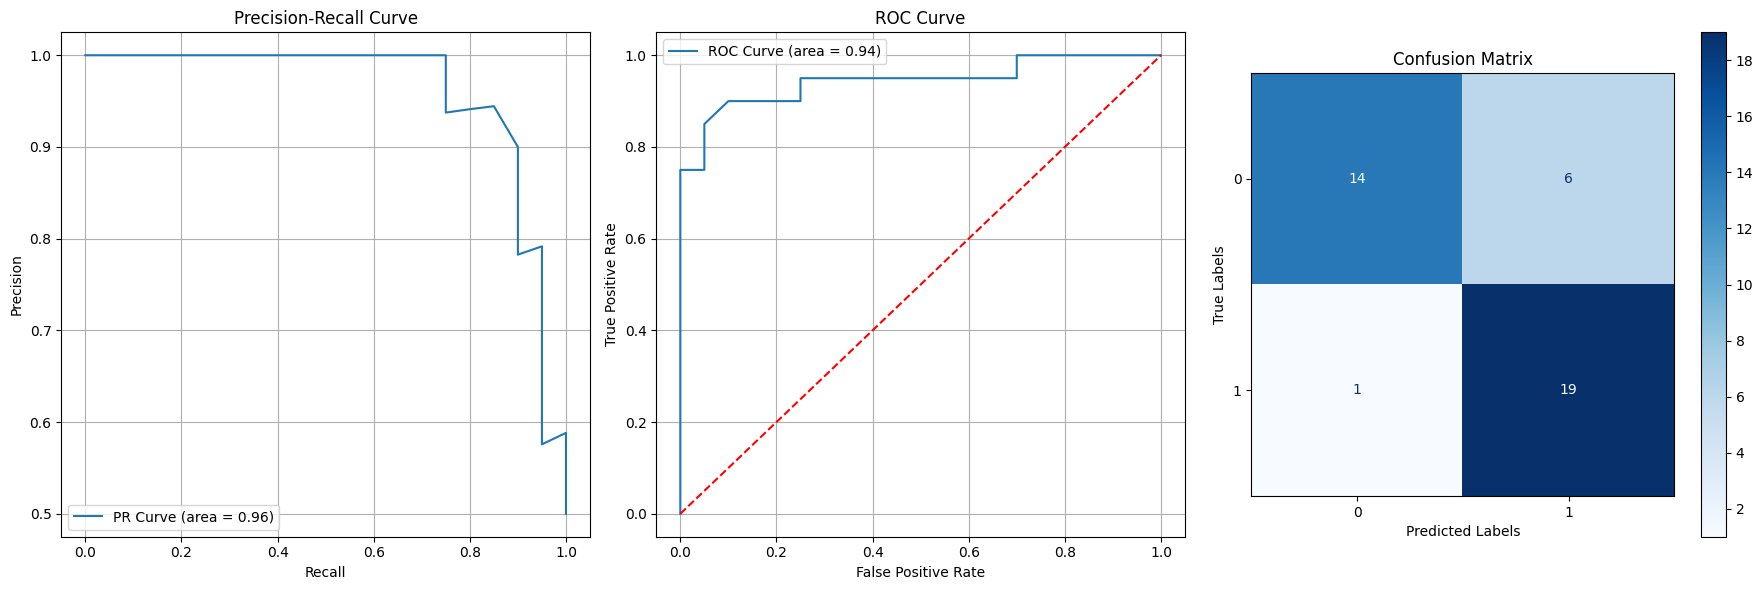

In [16]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(test_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs)

AUPRC: 0.9815
AUROC: 0.9792
Threshold: 0.5000
Precision: 1.0000
Recall: 0.7200
F1 Score: 0.8372
Accuracy: 0.8600


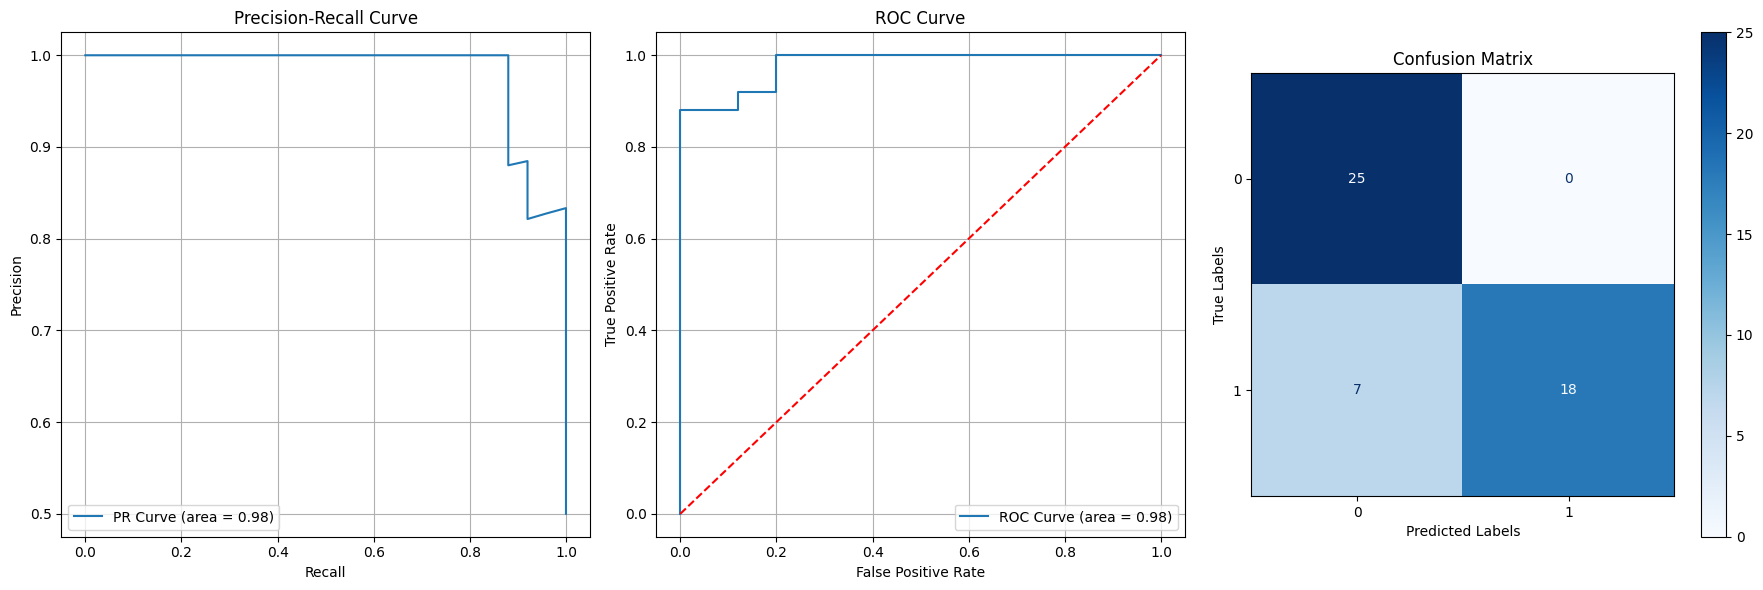

In [17]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(deploy_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs)

In [18]:
model = torch.load('/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/models/GPT2/GPT2-kagglewiki-nometa.pth')
model.to(device)
model_utility = ModelUtility(model, device)

AUPRC: 0.9439
AUROC: 0.9200
Threshold: 0.5000
Precision: 0.9000
Recall: 0.9000
F1 Score: 0.9000
Accuracy: 0.9000


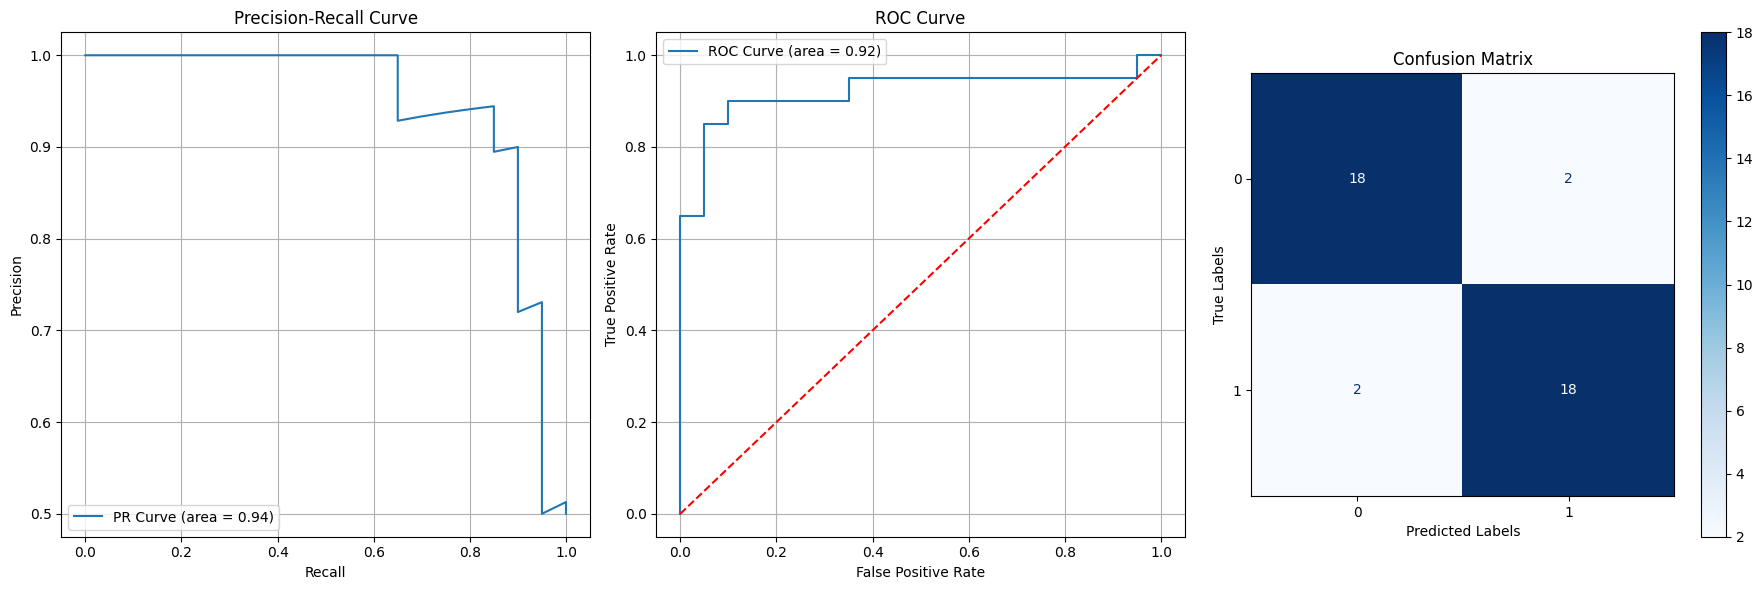

In [19]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(test_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs)

AUPRC: 0.9359
AUROC: 0.9136
Threshold: 0.5000
Precision: 1.0000
Recall: 0.2000
F1 Score: 0.3333
Accuracy: 0.6000


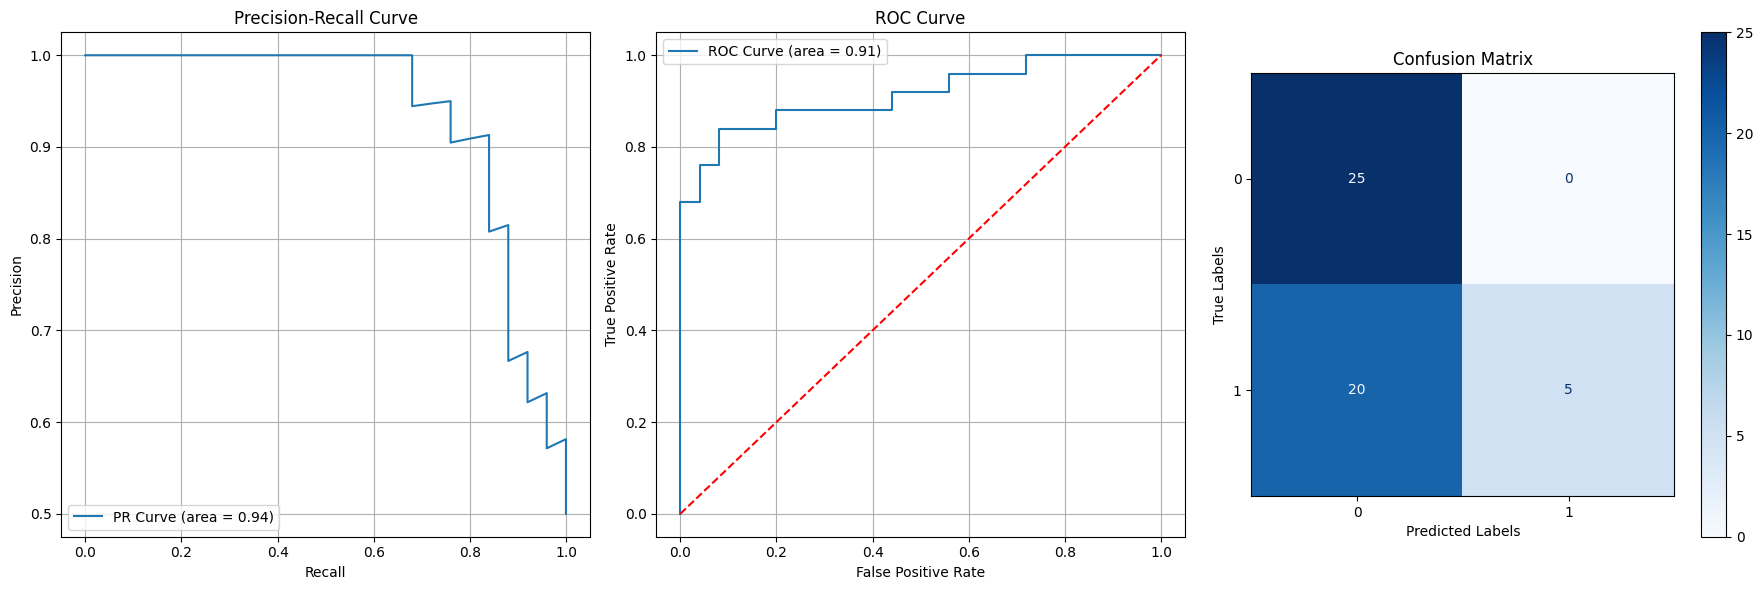

In [20]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(deploy_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs)

## with meta features

In [21]:
test_dataset = TextMetaDataset(df_test, tokenizer)
deploy_dataset = TextMetaDataset(df_deploy, tokenizer)

test_loader = DataLoader(dataset=test_dataset, batch_size=1)
deploy_loader = DataLoader(dataset=deploy_dataset, batch_size=1)

In [22]:
model = torch.load('/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/models/GPT2/GPT2-kagglewiki-withmeta.pth')
model.to(device)
model_utility = ModelUtility(model, device)

AUPRC: 0.9329
AUROC: 0.9125
Threshold: 0.5000
Precision: 0.8182
Recall: 0.9000
F1 Score: 0.8571
Accuracy: 0.8500


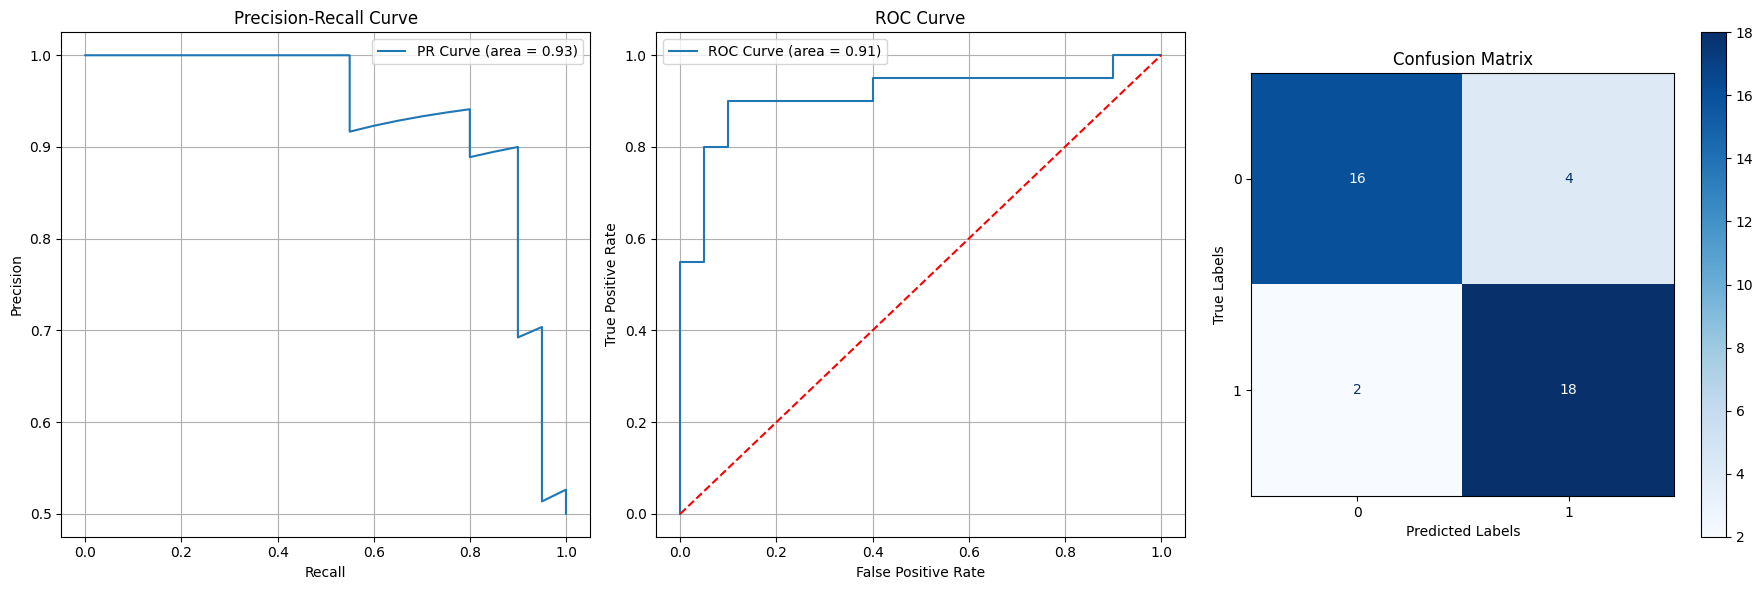

In [23]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(test_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs)

AUPRC: 0.8951
AUROC: 0.9440
Threshold: 0.5000
Precision: 0.9167
Recall: 0.8800
F1 Score: 0.8980
Accuracy: 0.9000


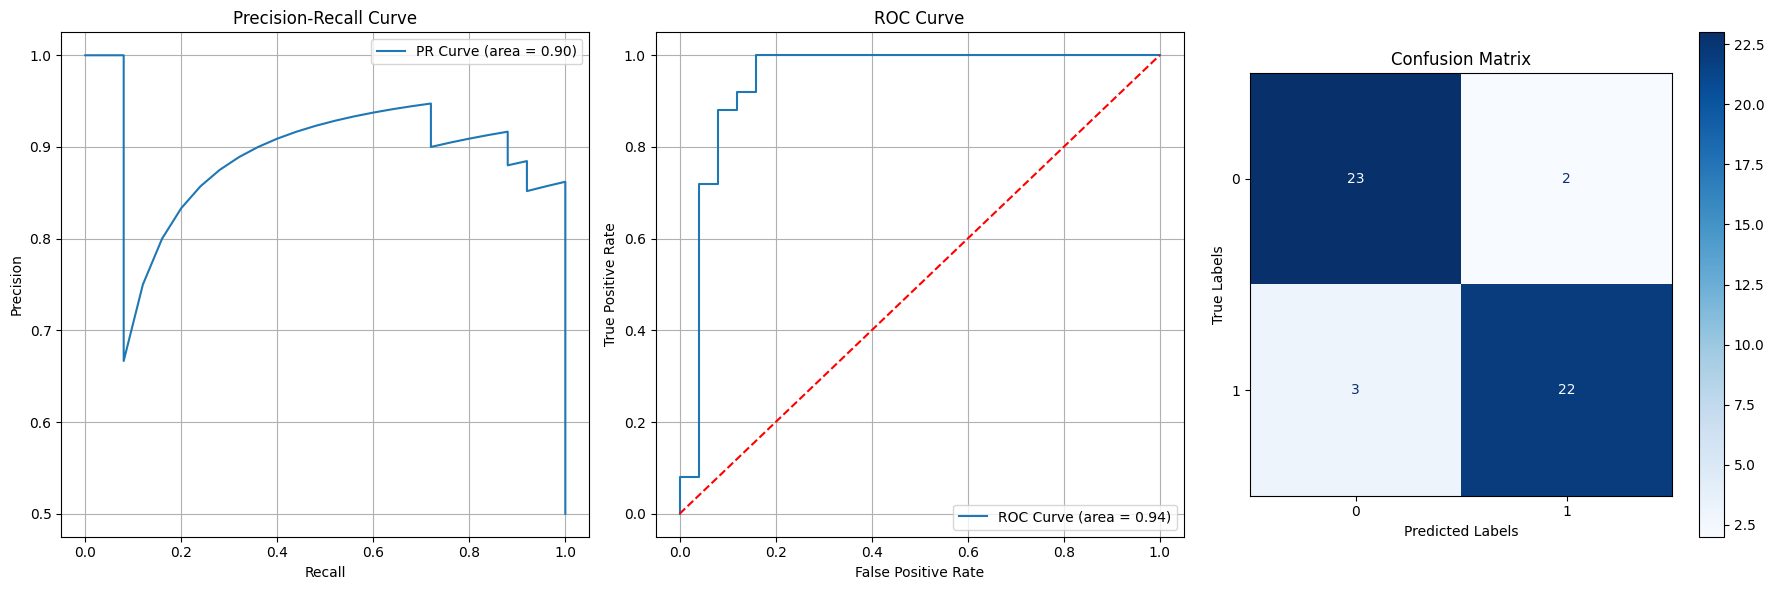

In [24]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(deploy_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs)

In [25]:
model = torch.load('/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/models/GPT2/GPT2-kaggle-withmeta.pth')
model.to(device)
model_utility = ModelUtility(model, device)

AUPRC: 0.8926
AUROC: 0.8775
Threshold: 0.5000
Precision: 0.9375
Recall: 0.7500
F1 Score: 0.8333
Accuracy: 0.8500


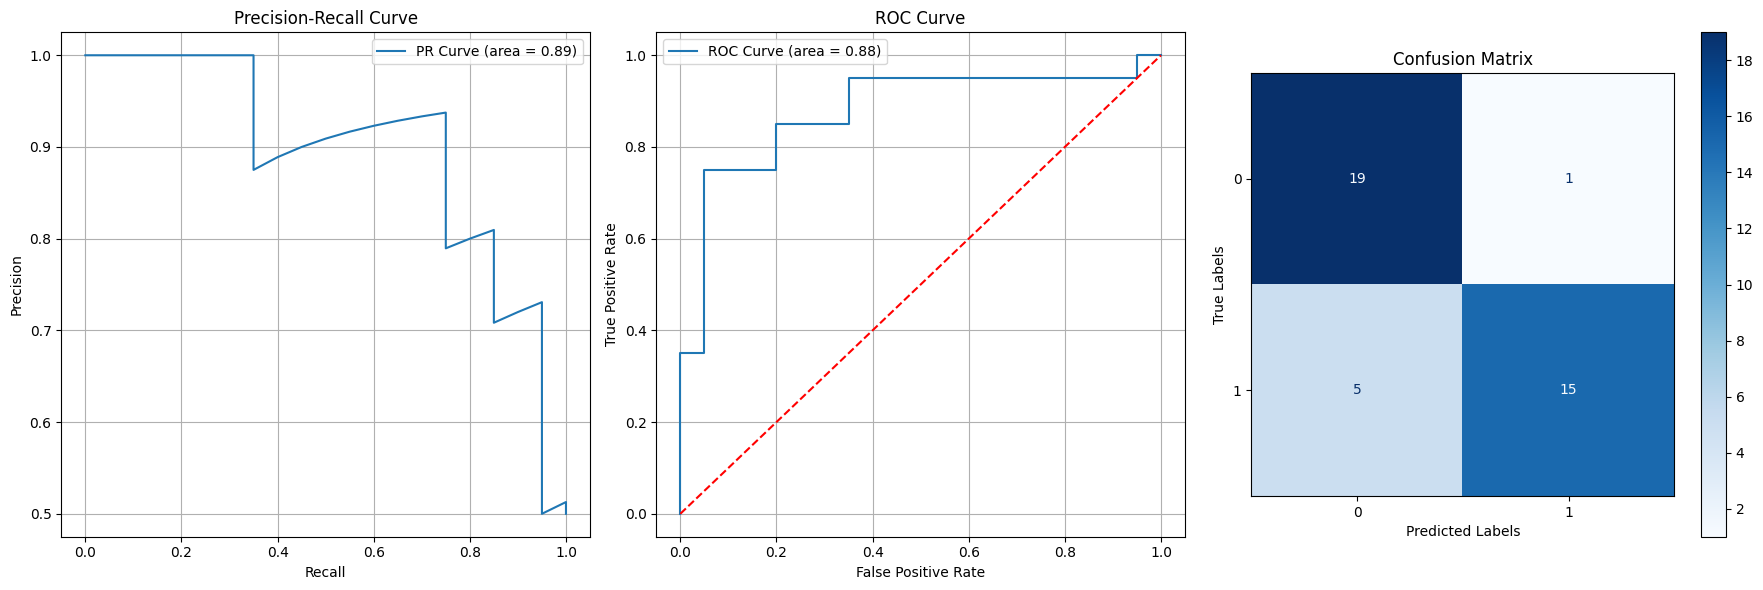

In [26]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(test_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs)

AUPRC: 0.9056
AUROC: 0.8992
Threshold: 0.5000
Precision: 0.8333
Recall: 0.6000
F1 Score: 0.6977
Accuracy: 0.7400


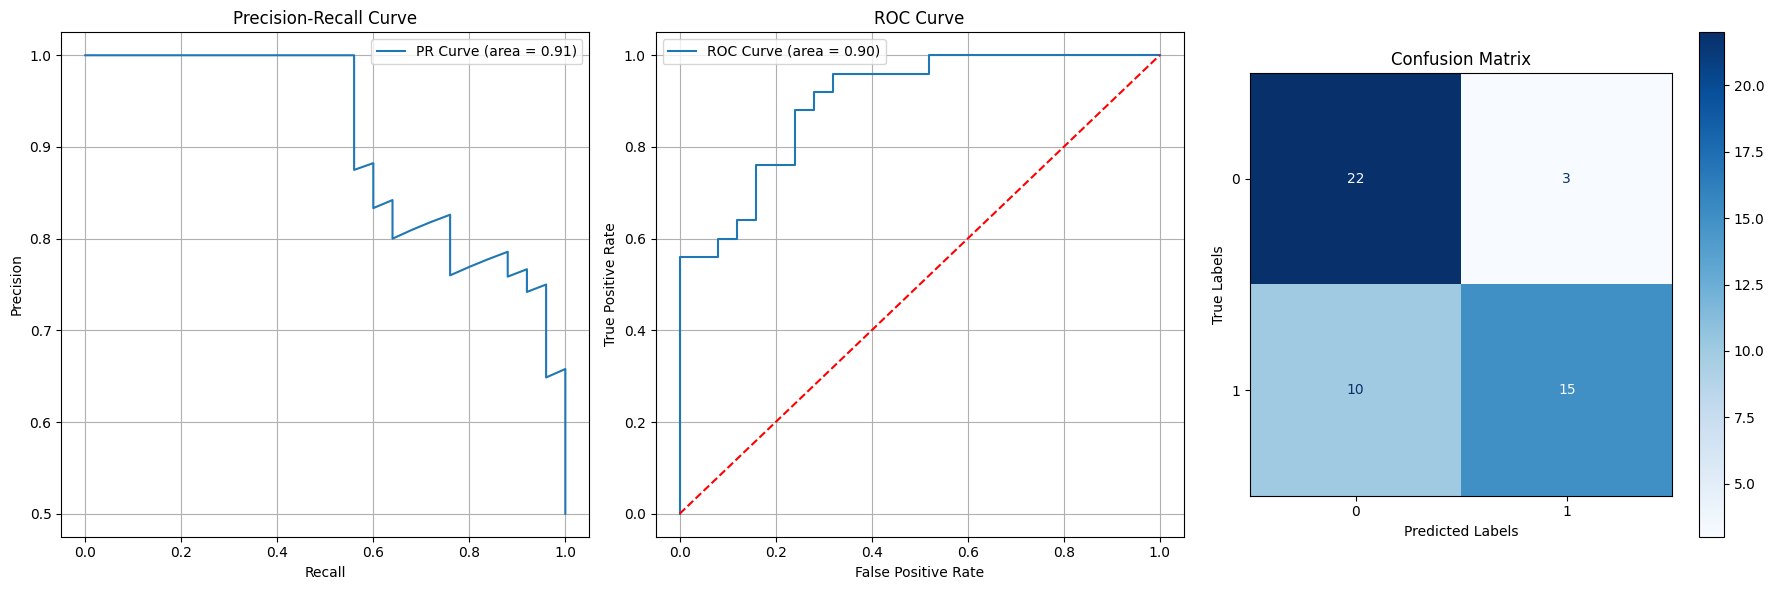

In [27]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(deploy_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs)

# XLnet

In [90]:
tokenizer = transformers.XLNetTokenizer.from_pretrained('xlnet-base-cased')

## text only

In [ ]:
class XLNetLightningModule(pl.LightningModule):
    def __init__(self, model_name, num_labels=2, learning_rate=2e-5):
        super().__init__()
        self.save_hyperparameters()
        self.xlnet = transformers.AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.learning_rate = learning_rate

    def forward(self, input_ids, attention_mask):
        outputs = self.xlnet(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        logits = self(input_ids, attention_mask)
        loss = F.cross_entropy(logits, labels)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        logits = self(input_ids, attention_mask)
        loss = F.cross_entropy(logits, labels)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        return optimizer

In [91]:
model = XLNetLightningModule('xlnet-base-cased')

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [92]:
test_dataset = TextDataset(df_test, tokenizer)
deploy_dataset = TextDataset(df_deploy, tokenizer)

test_loader = DataLoader(dataset=test_dataset, batch_size=1)
deploy_loader = DataLoader(dataset=deploy_dataset, batch_size=1)

In [93]:
model = torch.load('/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/models/XLnet/XLnet_kaggle_nometa.pth')
model.to(device)
model_utility = ModelUtility(model, device)

AUPRC: 0.8656
AUROC: 0.8850
Threshold: 0.5000
Precision: 0.5556
Recall: 1.0000
F1 Score: 0.7143
Accuracy: 0.6000


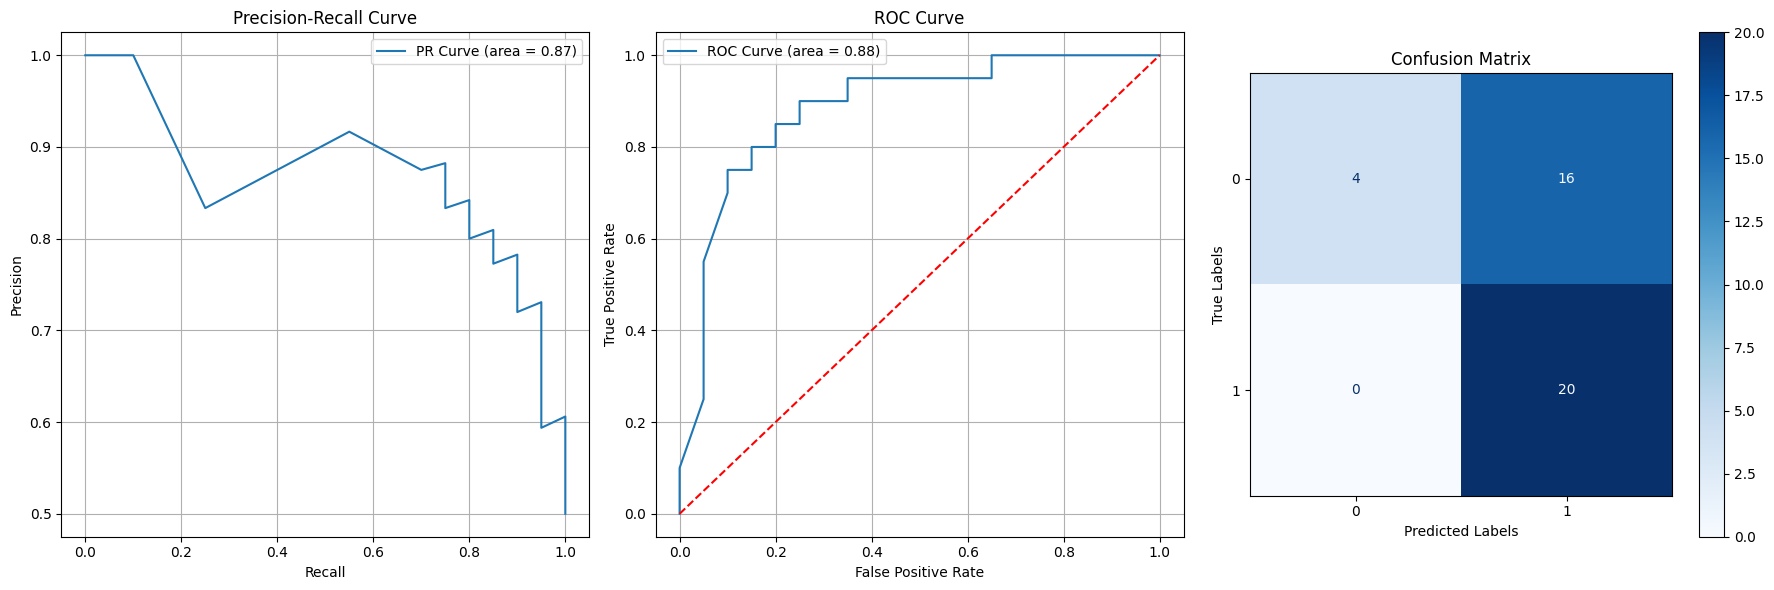

In [94]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(test_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs)

AUPRC: 0.9480
AUROC: 0.9408
Threshold: 0.5000
Precision: 0.9200
Recall: 0.9200
F1 Score: 0.9200
Accuracy: 0.9200


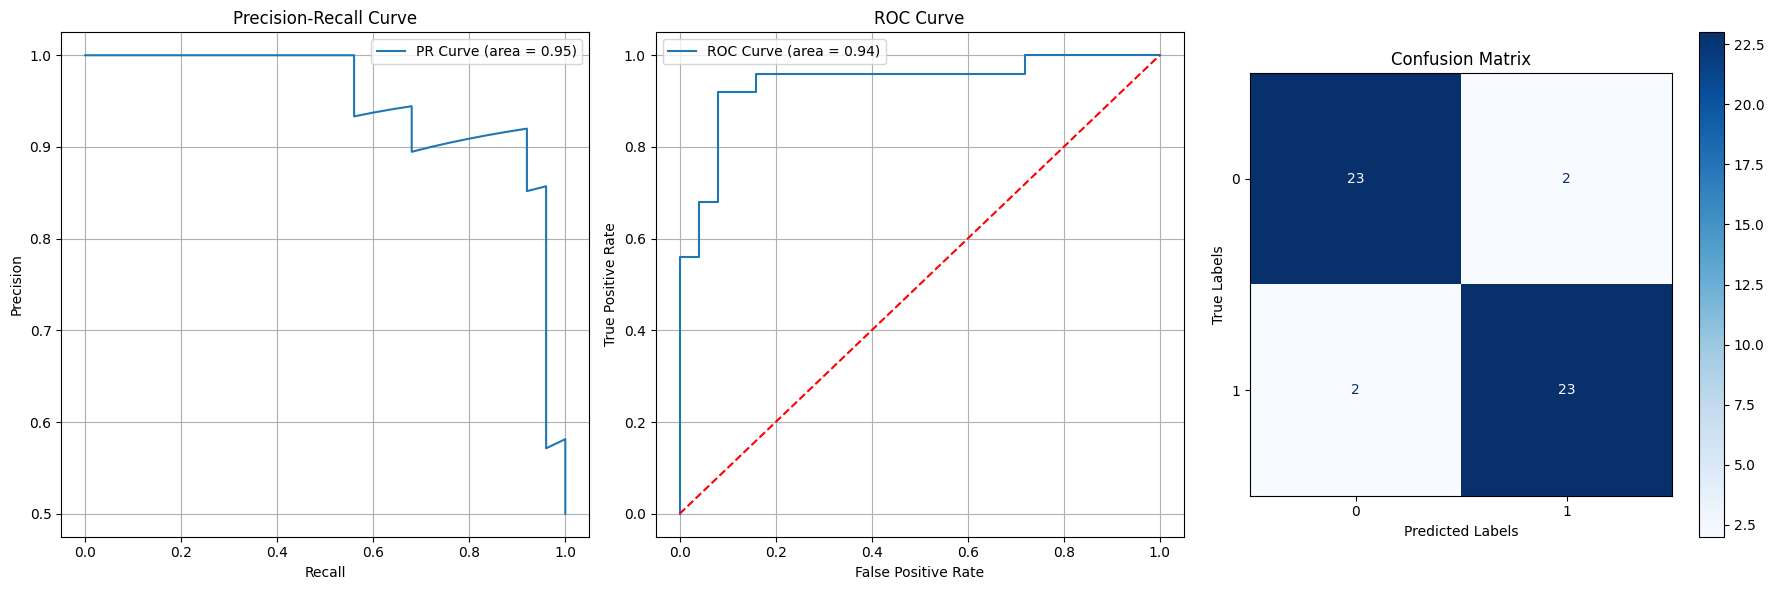

In [51]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(deploy_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs)

In [95]:
model = torch.load('/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/models/XLnet/XLnet-kagglewiki-nometa.pth')
model.to(device)
model_utility = ModelUtility(model, device)

AUPRC: 0.9633
AUROC: 0.9450
Threshold: 0.5000
Precision: 0.8182
Recall: 0.9000
F1 Score: 0.8571
Accuracy: 0.8500


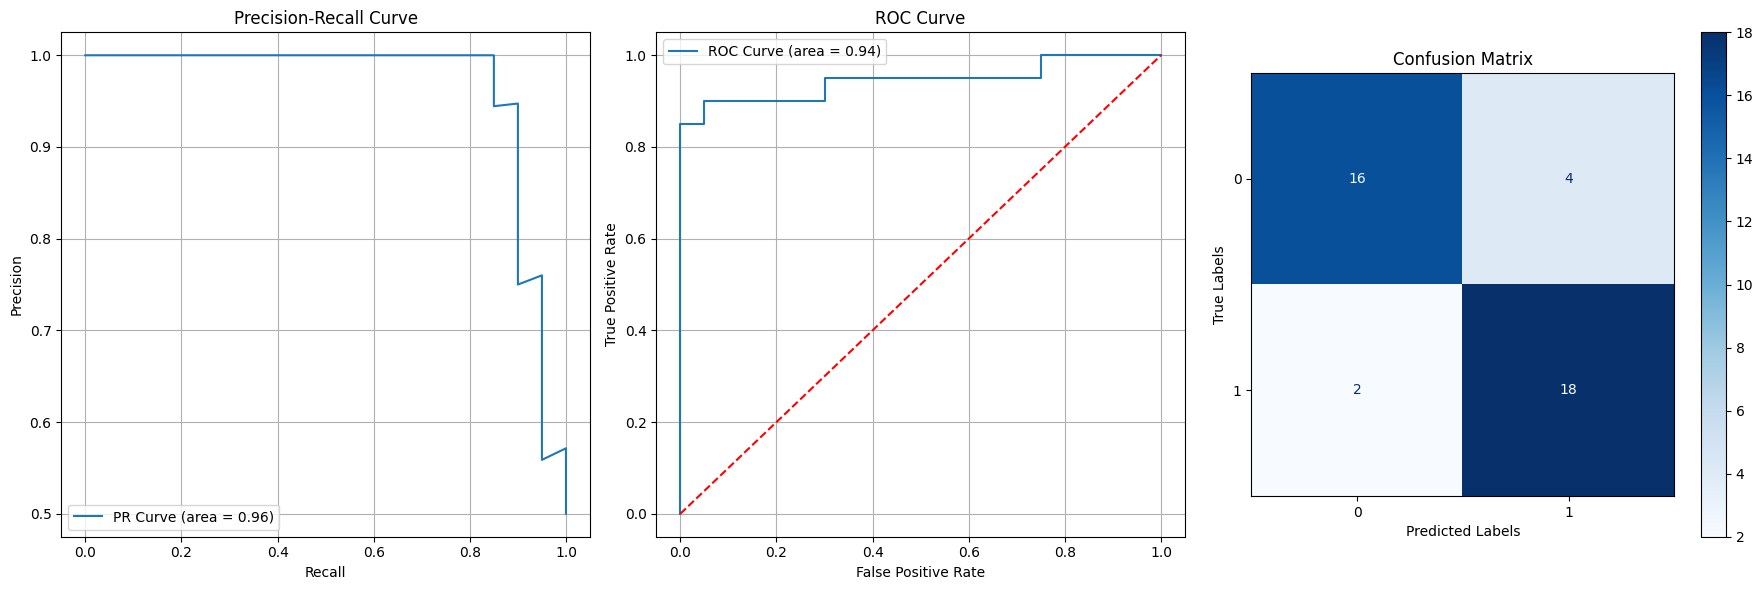

In [96]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(test_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs)

AUPRC: 0.9125
AUROC: 0.9008
Threshold: 0.5000
Precision: 0.9333
Recall: 0.5600
F1 Score: 0.7000
Accuracy: 0.7600


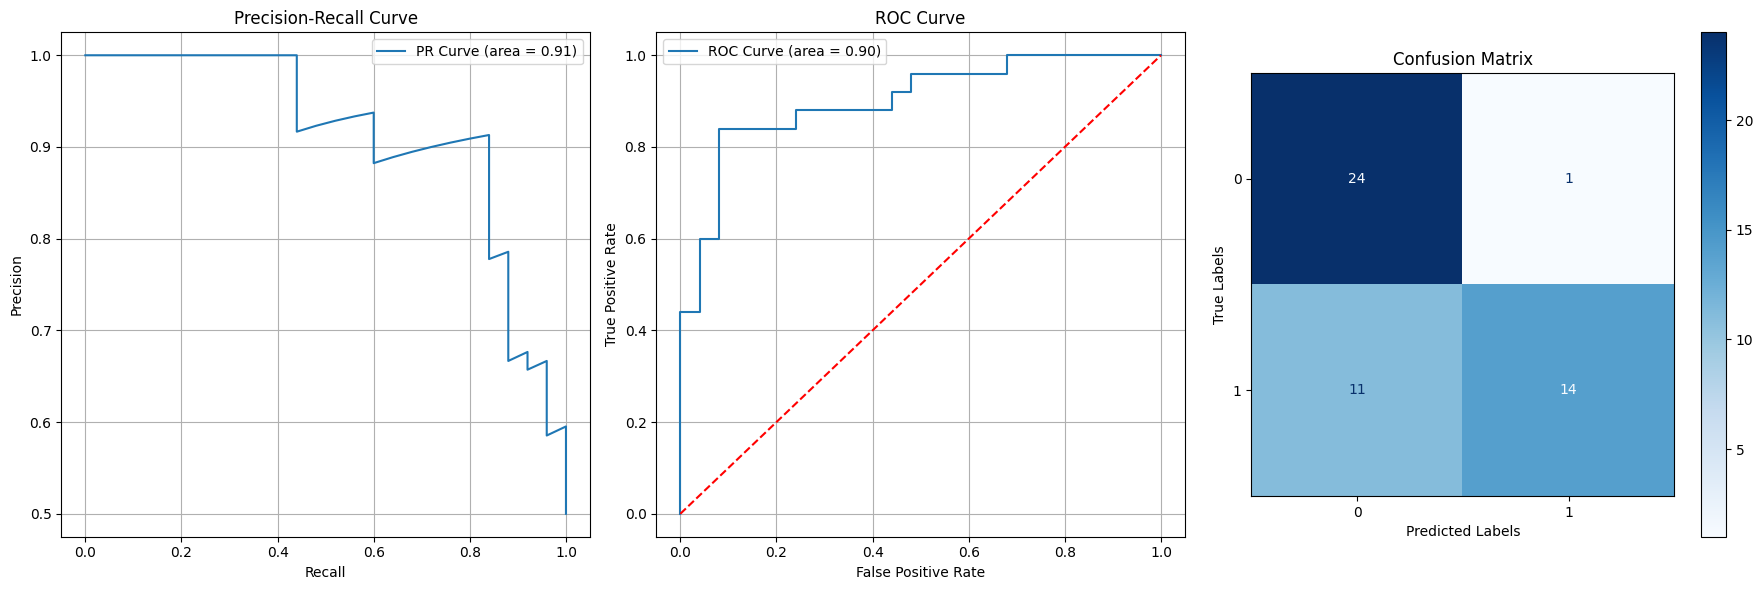

In [54]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(deploy_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs)

## with meta features

In [ ]:
class XLNetMetaLightningModule(pl.LightningModule):
    def __init__(self, model_name, config, num_labels=2):
        super().__init__()
        # Initialize the XLNet model for sequence classification
        self.xlnet = transformers.XLNetForSequenceClassification.from_pretrained(model_name, config=config)

        self.meta_feature_processor = nn.Sequential(
            nn.Linear(4, 16),  # 4 metafeatures
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU()
        )
        # Classifier that uses combined XLNet features and metafeatures
        combined_features_dim = self.xlnet.config.hidden_size + 16  # Assuming the hidden size from XLNet and meta features
        self.classifier = nn.Linear(combined_features_dim, num_labels)

    def forward(self, input_ids, attention_mask, meta_features):
        outputs = self.xlnet(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.hidden_states[-1]
        xlnet_features = last_hidden_state[:, 0, :]   # Get the features from the CLS token

        meta_features = self.meta_feature_processor(meta_features)

        combined_features = torch.cat((xlnet_features, meta_features), dim=1)

        logits = self.classifier(combined_features)
        return logits

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        meta_features = batch['meta_features']
        labels = batch['label']
        logits = self(input_ids, attention_mask, meta_features)
        loss = F.cross_entropy(logits, labels)
        preds = torch.argmax(logits, dim=1)
        probs = torch.softmax(logits, dim=1)[:, 1]
        self.log('train_loss', loss, on_step=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        meta_features = batch['meta_features']
        labels = batch['label']
        logits = self(input_ids, attention_mask, meta_features)
        loss = F.cross_entropy(logits, labels)
        preds = torch.argmax(logits, dim=1)
        probs = torch.softmax(logits, dim=1)[:, 1]
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=5e-5)
        return optimizer

In [80]:
tokenizer = transformers.XLNetTokenizer.from_pretrained('xlnet-base-cased')
config = transformers.XLNetConfig.from_pretrained('xlnet-base-cased', num_labels=2, output_hidden_states=True)
model = XLNetMetaLightningModule('xlnet-base-cased', config)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [55]:
test_dataset = TextMetaDataset(df_test, tokenizer)
deploy_dataset = TextMetaDataset(df_deploy, tokenizer)

test_loader = DataLoader(dataset=test_dataset, batch_size=1)
deploy_loader = DataLoader(dataset=deploy_dataset, batch_size=1)

In [81]:
state_dict = torch.load('/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/models/XLnet/XLnet_kaggle_withmeta_checkpoint.pth')
model.load_state_dict(state_dict)
model.to(device)
model_utility = ModelUtility(model, device)

AUPRC: 0.9613
AUROC: 0.9450
Threshold: 0.5000
Precision: 0.5714
Recall: 1.0000
F1 Score: 0.7273
Accuracy: 0.6250


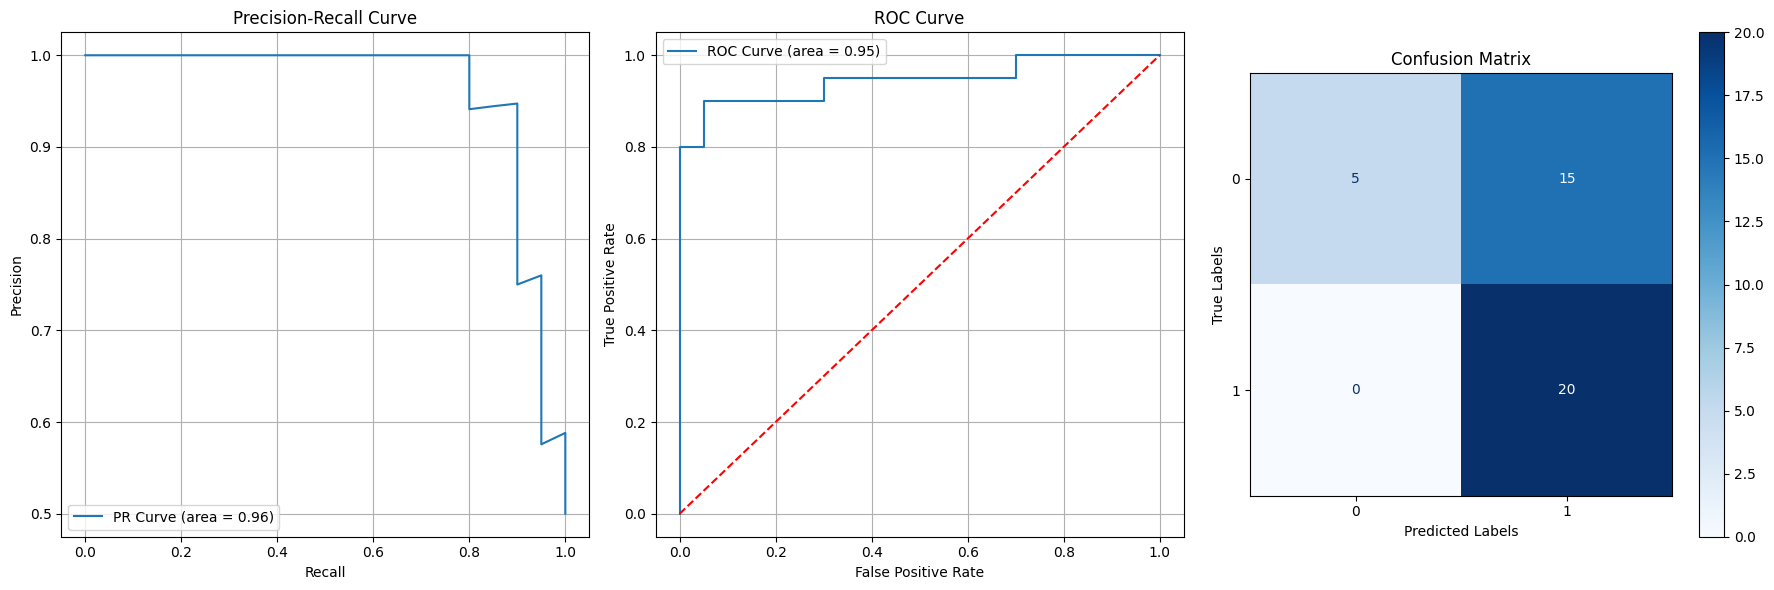

In [82]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(test_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs)

AUPRC: 0.9647
AUROC: 0.9632
Threshold: 0.5000
Precision: 0.8571
Recall: 0.9600
F1 Score: 0.9057
Accuracy: 0.9000


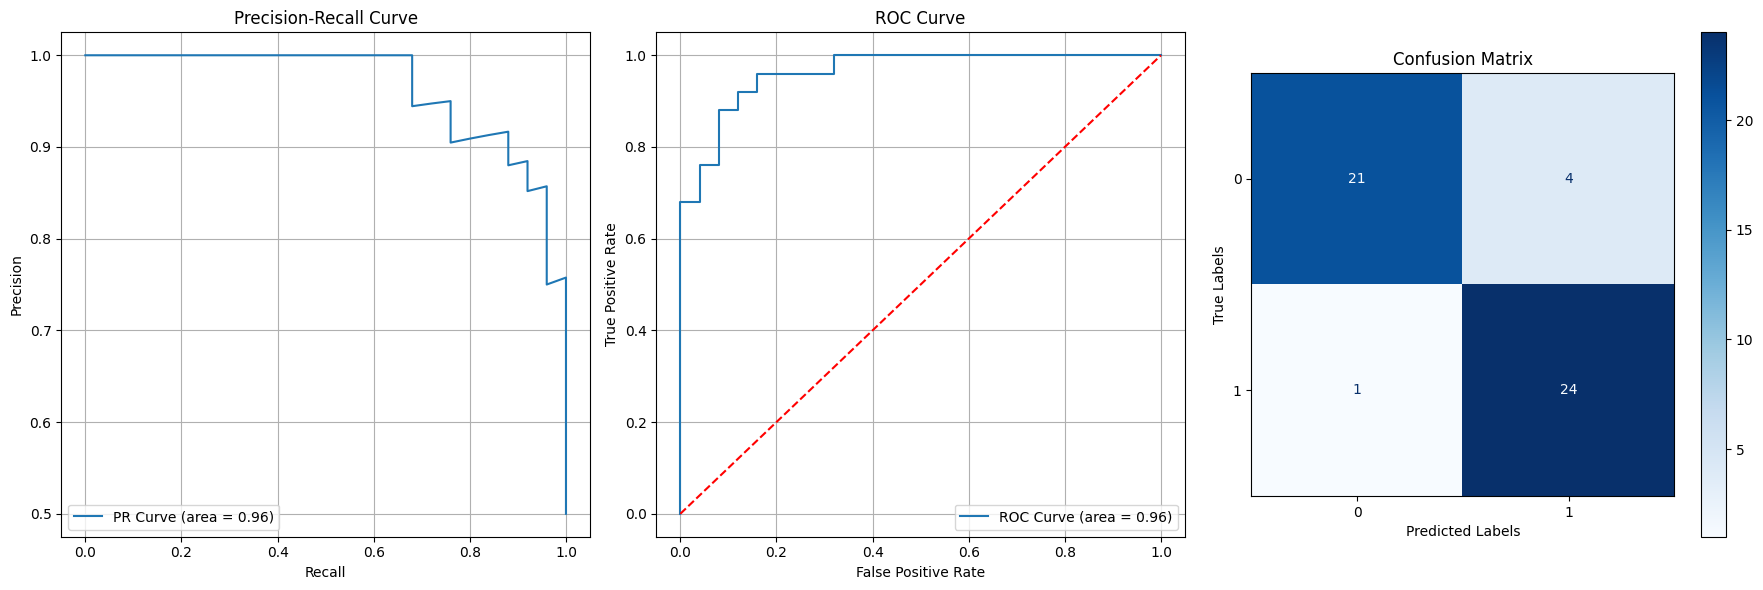

In [83]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(deploy_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs)

In [88]:
model = XLNetMetaLightningModule('xlnet-base-cased', config)
state_dict = torch.load('/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/models/XLnet/XLnet_kagglewiki_withmeta_checkpoint.pth')
model.load_state_dict(state_dict)
model.to(device)
model_utility = ModelUtility(model, device)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AUPRC: 0.9734
AUROC: 0.9525
Threshold: 0.5000
Precision: 0.9474
Recall: 0.9000
F1 Score: 0.9231
Accuracy: 0.9250


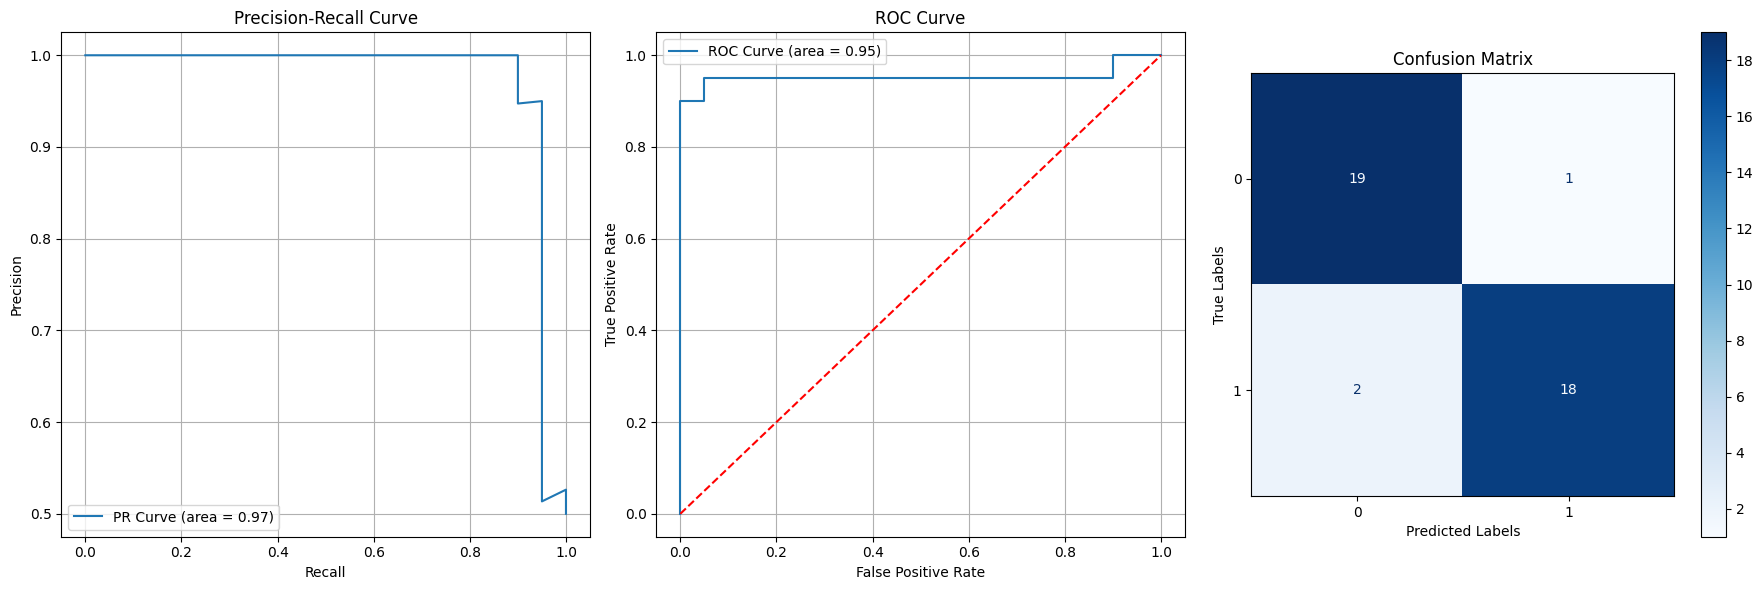

In [89]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(test_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs)

In [ ]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(deploy_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs)

# DistilBert

In [112]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

## text only

In [ ]:
class LightningModule(pl.LightningModule):
    def __init__(self, model_name, num_labels=2, learning_rate=2e-5):
        super().__init__()
        self.save_hyperparameters()
        self.model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.learning_rate = learning_rate

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        logits = self(input_ids, attention_mask)
        loss = F.cross_entropy(logits, labels)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        logits = self(input_ids, attention_mask)
        loss = F.cross_entropy(logits, labels)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        return optimizer

In [113]:
test_dataset = TextDataset(df_test, tokenizer)
deploy_dataset = TextDataset(df_deploy, tokenizer)

test_loader = DataLoader(dataset=test_dataset, batch_size=1)
deploy_loader = DataLoader(dataset=deploy_dataset, batch_size=1)

model = LightningModule('distilbert-base-uncased')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [114]:
model = torch.load('/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/models/DistilBert/DistilBert_kagglewiki_nometa.pth')
model.to(device)
model_utility = ModelUtility(model, device)

AUPRC: 0.9536
AUROC: 0.9500
Threshold: 0.5000
Precision: 1.0000
Recall: 0.4000
F1 Score: 0.5714
Accuracy: 0.7000


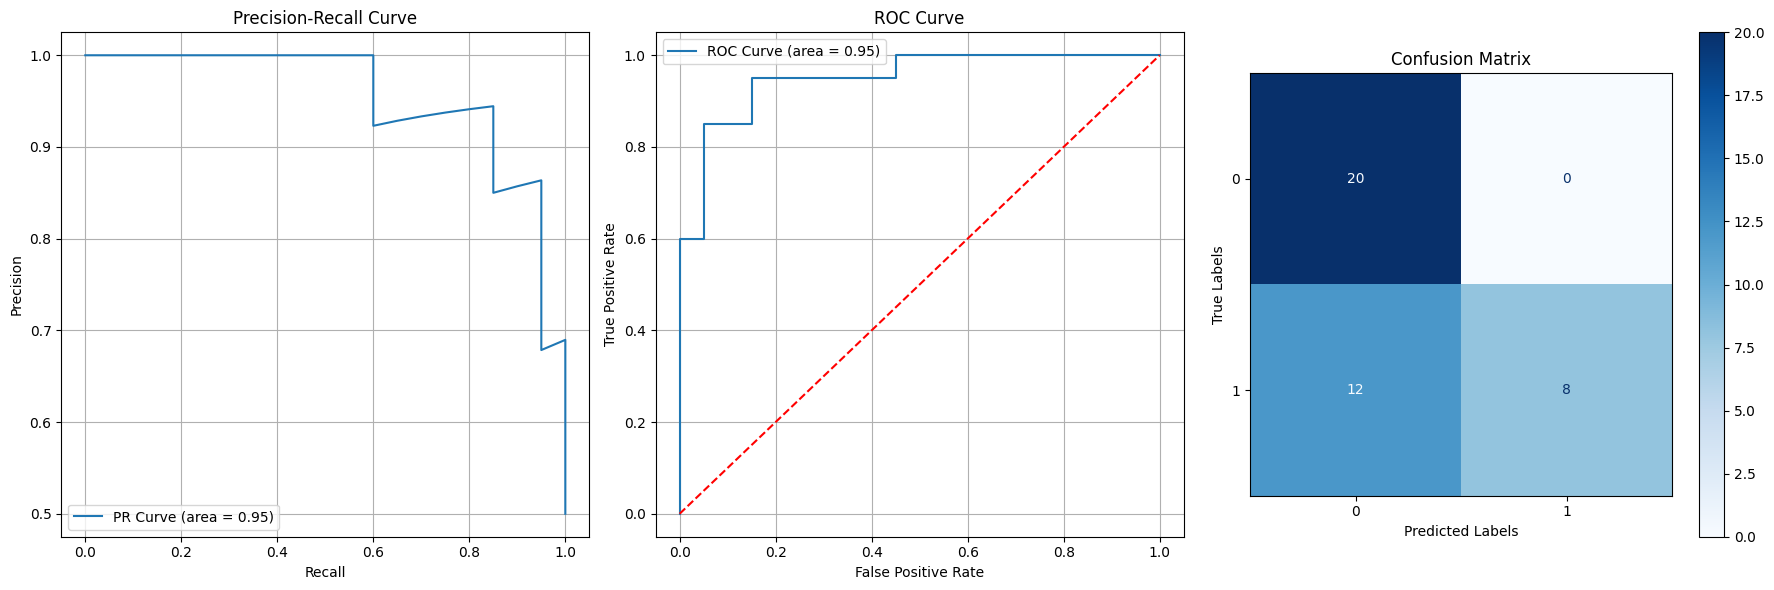

In [115]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(test_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs)

AUPRC: 0.9292
AUROC: 0.9184
Threshold: 0.5000
Precision: 1.0000
Recall: 0.0400
F1 Score: 0.0769
Accuracy: 0.5200


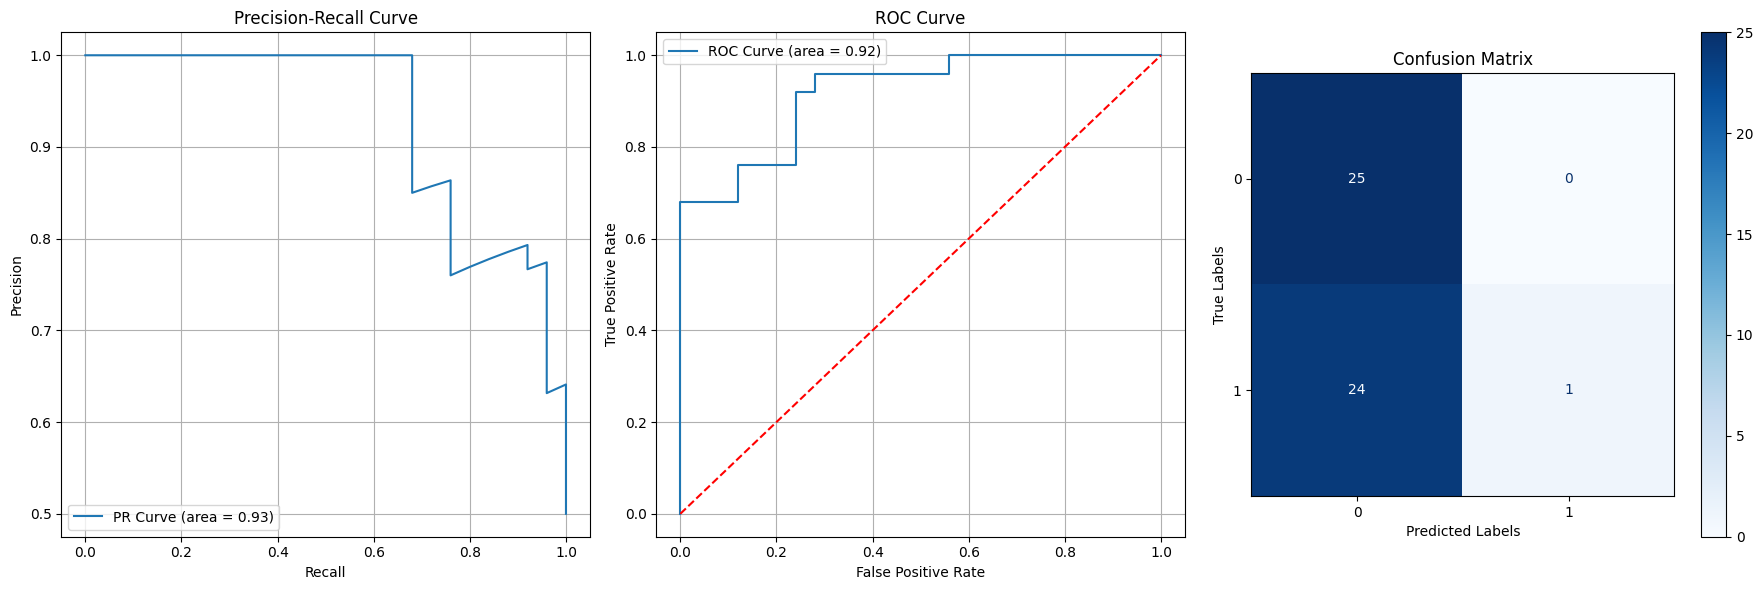

In [116]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(deploy_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs)

In [104]:
model = torch.load('/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/models/DistilBert/DistilBert_kaggle_nometa.pth')
model.to(device)
model_utility = ModelUtility(model, device)

AUPRC: 0.9576
AUROC: 0.9325
Threshold: 0.5000
Precision: 0.7200
Recall: 0.9000
F1 Score: 0.8000
Accuracy: 0.7750


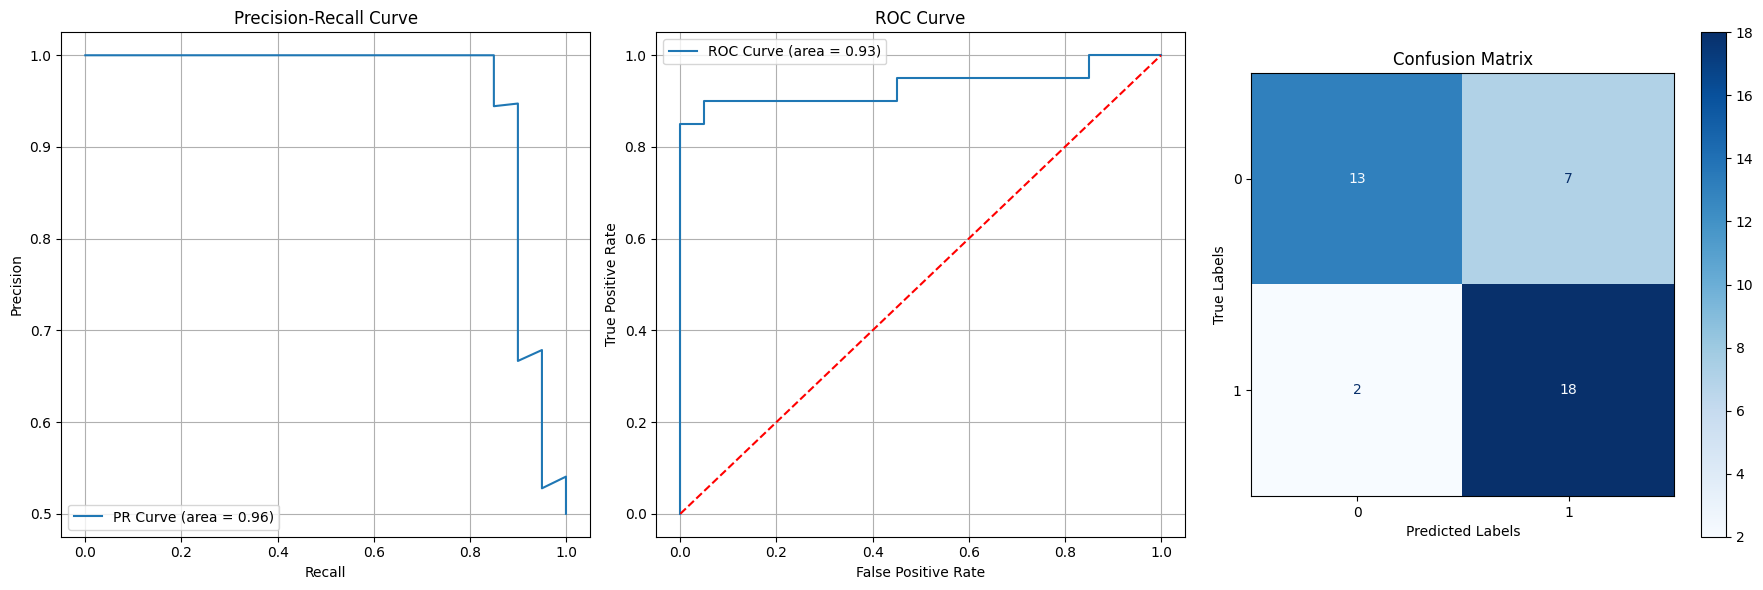

In [105]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(test_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs)

AUPRC: 0.9565
AUROC: 0.9520
Threshold: 0.5000
Precision: 1.0000
Recall: 0.3200
F1 Score: 0.4848
Accuracy: 0.6600


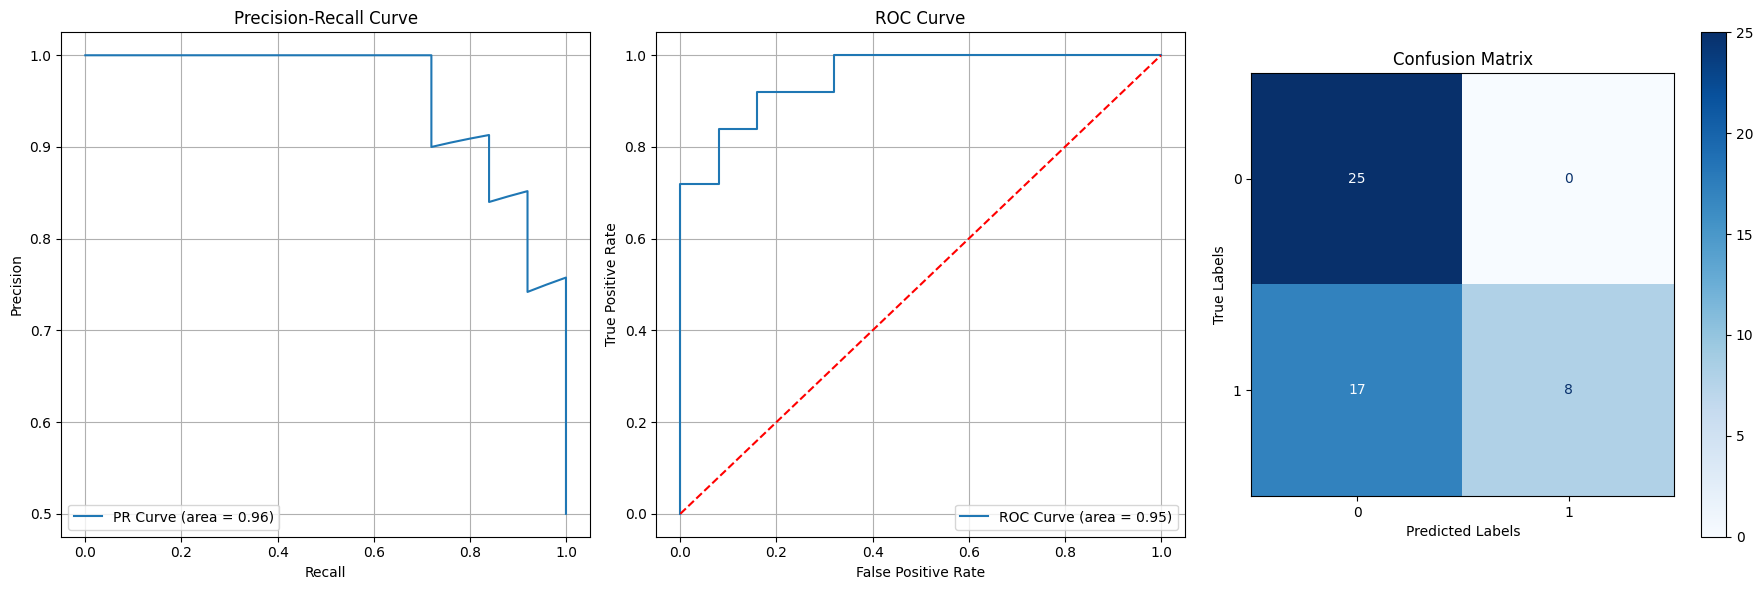

In [106]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(deploy_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs)

## with meta

In [15]:
class LightningModule(pl.LightningModule):
    def __init__(self, model_name, config, num_labels=2):
        super().__init__()
        # Initialize the XLNet model for sequence classification
        self.model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

        self.meta_feature_processor = nn.Sequential(
            nn.Linear(4, 16),  # 4 metafeatures
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU()
        )

        combined_features_dim = self.model.config.hidden_size + 16  # Assuming the hidden size from XLNet and meta features
        self.classifier = nn.Linear(combined_features_dim, num_labels)

    def forward(self, input_ids, attention_mask, meta_features):

        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.hidden_states[-1]
        sequence_features = last_hidden_state[:, 0, :]   # Get the features from the CLS token

        # Process metafeatures through the feed-forward network
        meta_features = self.meta_feature_processor(meta_features)


        combined_features = torch.cat((sequence_features, meta_features), dim=1)

        # Pass the combined features through the classifier
        logits = self.classifier(combined_features)
        return logits

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        meta_features = batch['meta_features']
        labels = batch['label']
        logits = self(input_ids, attention_mask, meta_features)
        loss = F.cross_entropy(logits, labels)
        preds = torch.argmax(logits, dim=1)
        probs = torch.softmax(logits, dim=1)[:, 1]
        self.log('train_loss', loss, on_step=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        meta_features = batch['meta_features']
        labels = batch['label']
        logits = self(input_ids, attention_mask, meta_features)
        loss = F.cross_entropy(logits, labels)
        preds = torch.argmax(logits, dim=1)
        probs = torch.softmax(logits, dim=1)[:, 1]
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=2e-5)
        return optimizer

In [16]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
config = transformers.DistilBertConfig.from_pretrained('distilbert-base-uncased', num_labels=2, output_hidden_states=True)
model = LightningModule('distilbert-base-uncased', config)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
test_dataset = TextMetaDataset(df_test, tokenizer)
deploy_dataset = TextMetaDataset(df_deploy, tokenizer)

test_loader = DataLoader(dataset=test_dataset, batch_size=1)
deploy_loader = DataLoader(dataset=deploy_dataset, batch_size=1)

In [18]:
model = torch.load('/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/models/DistilBert/DistilBert_kagglewiki_withmeta.pth')
model.to(device)
model_utility = ModelUtility(model, device)

AUPRC: 0.9654
AUROC: 0.9500
Threshold: 0.5000
Precision: 0.8947
Recall: 0.8500
F1 Score: 0.8718
Accuracy: 0.8750


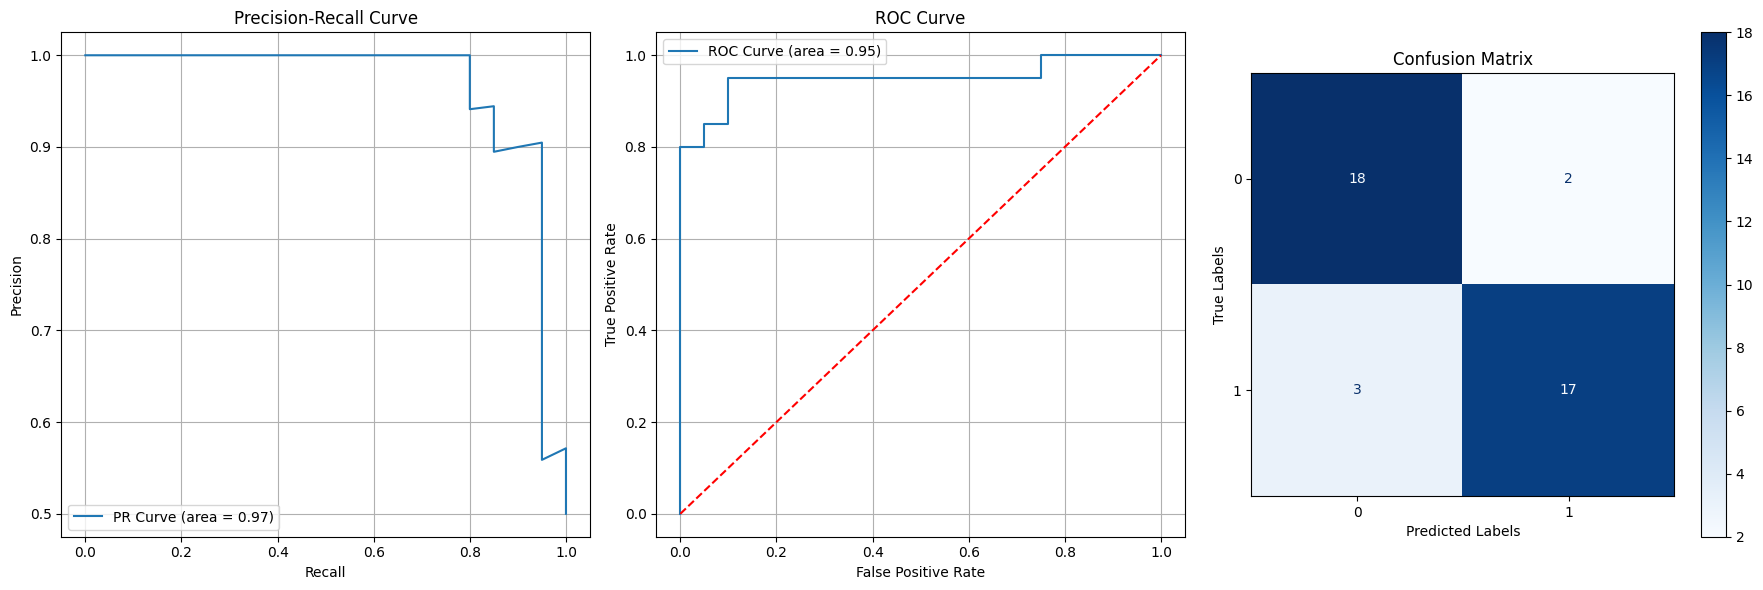

In [19]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(test_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs)

AUPRC: 0.9245
AUROC: 0.9120
Threshold: 0.5000
Precision: 1.0000
Recall: 0.2800
F1 Score: 0.4375
Accuracy: 0.6400


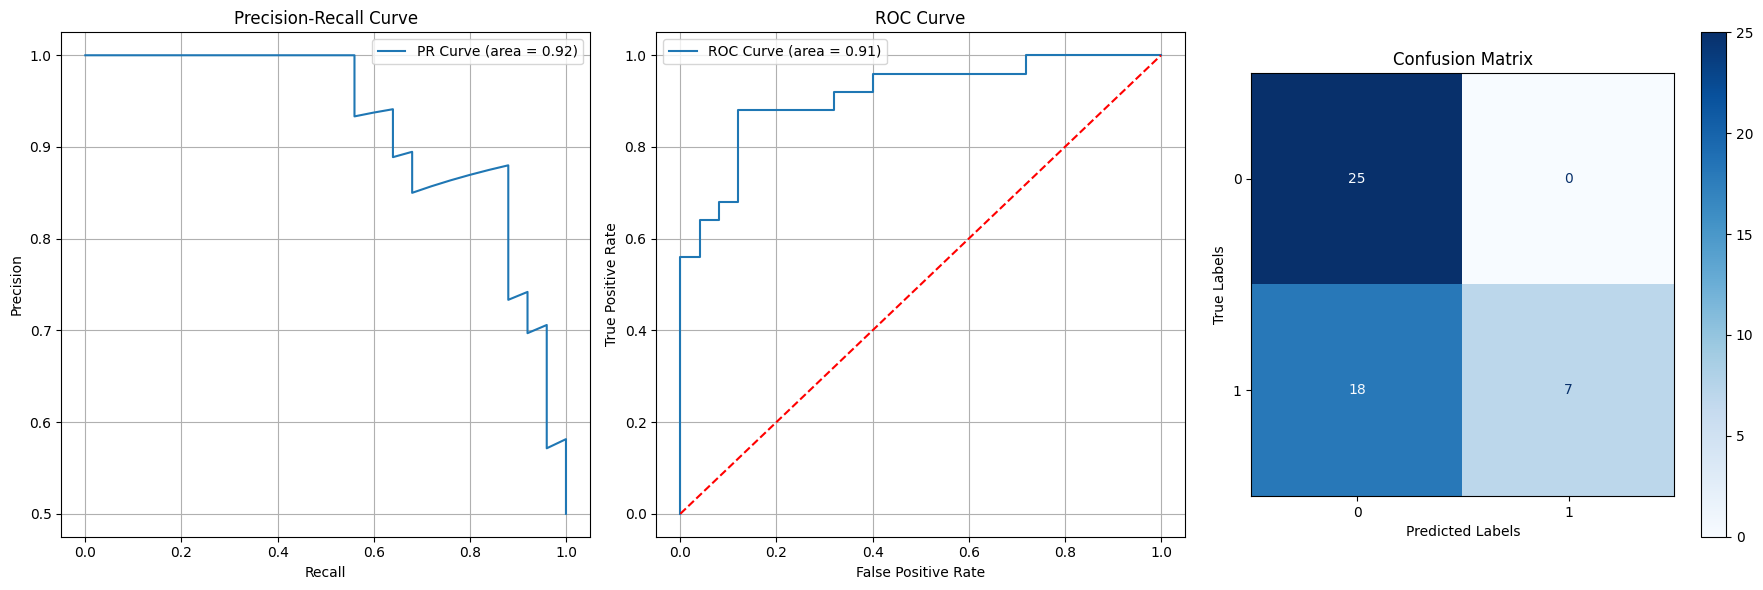

In [20]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(deploy_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs)

In [21]:
model = torch.load('/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/models/DistilBert/DistilBert_kaggle_withmeta.pth')
model.to(device)
model_utility = ModelUtility(model, device)

AUPRC: 0.9654
AUROC: 0.9500
Threshold: 0.5000
Precision: 0.8947
Recall: 0.8500
F1 Score: 0.8718
Accuracy: 0.8750


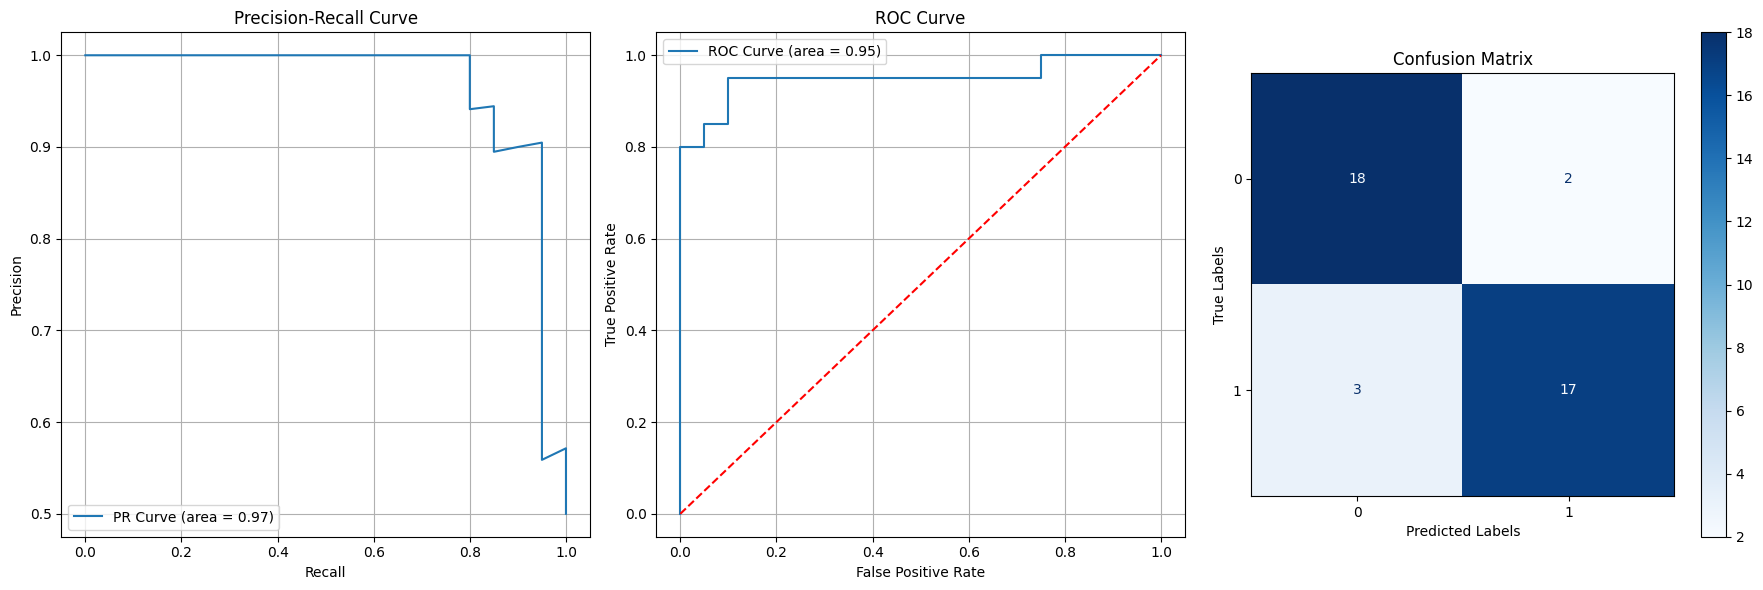

In [22]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(test_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs)

AUPRC: 0.9245
AUROC: 0.9120
Threshold: 0.5000
Precision: 1.0000
Recall: 0.2800
F1 Score: 0.4375
Accuracy: 0.6400


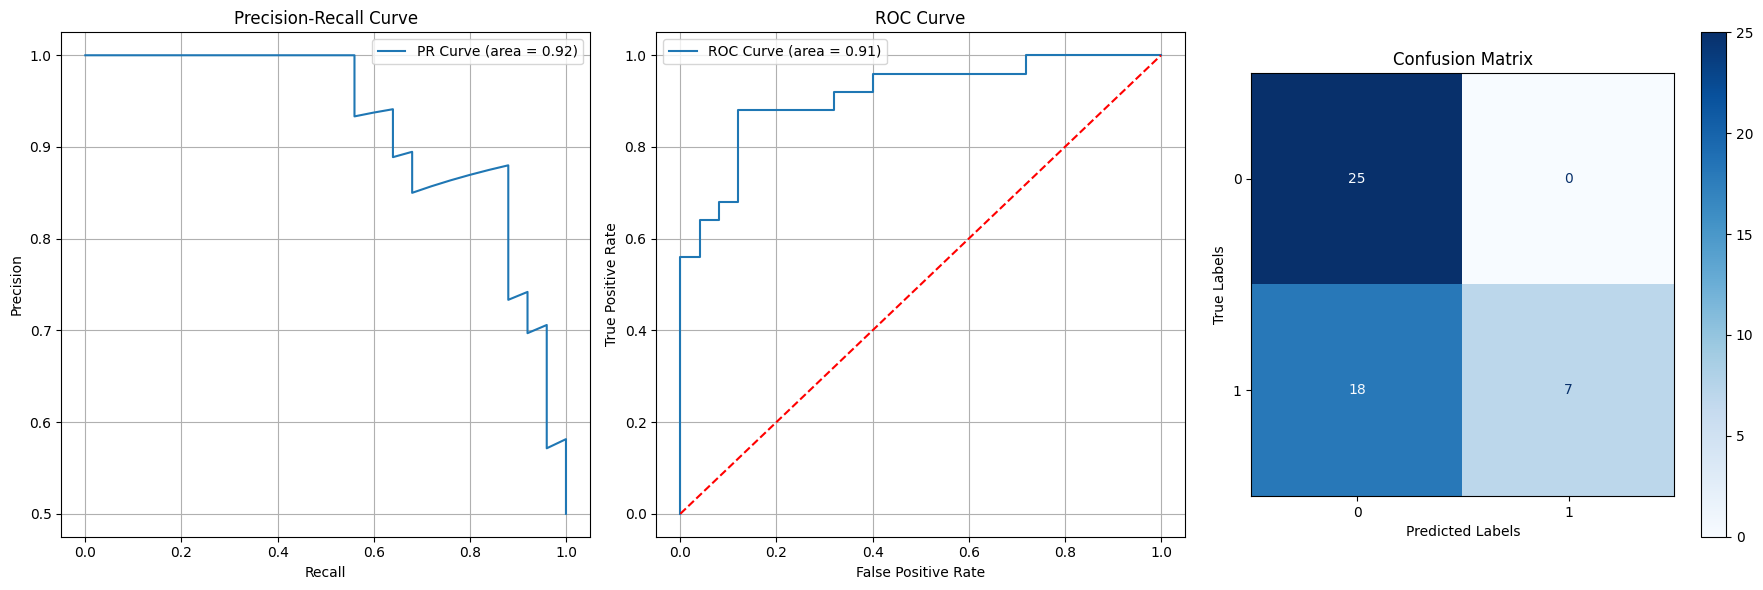

In [23]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(deploy_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs)

backup